# `causalml` - Meta-Learner Example Notebook
This notebook only contains regression examples.

In [ ]:
# pick the right base path (only run ONCE)
import os
base_path = os.path.abspath("../")
os.chdir(base_path)

In [ ]:
%reload_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor, XGBClassifier
import warnings

# from causalml.inference.meta import XGBTLearner, MLPTLearner
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.meta import LRSRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# imports from package
import logging
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
from copy import deepcopy

logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

%matplotlib inline

# Single Treatment Case

### Generate synthetic data

In [5]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array(['treatment_a' if val==1 else 'control' for val in treatment])

## S-Learner

### ATE

In [6]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False, bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9656
INFO:causalml:    RMSE (Treatment):     0.9597
INFO:causalml:   sMAPE   (Control):     0.8157
INFO:causalml:   sMAPE (Treatment):     0.4673
INFO:causalml:    Gini   (Control):     0.4323
INFO:causalml:    Gini (Treatment):     0.4801


In [7]:
ate_s

array([0.56213428])

### ATE w/ Confidence Intervals

In [8]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                   bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9656
INFO:causalml:    RMSE (Treatment):     0.9597
INFO:causalml:   sMAPE   (Control):     0.8157
INFO:causalml:   sMAPE (Treatment):     0.4673
INFO:causalml:    Gini   (Control):     0.4323
INFO:causalml:    Gini (Treatment):     0.4801


In [9]:
np.vstack((ate_s_lb, ate_s, ate_s_ub))

array([[0.52420113],
       [0.56213428],
       [0.60006744]])

### ATE w/ Boostrap Confidence Intervals

In [10]:
ate_s_b, ate_s_lb_b, ate_s_ub_b = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                         bootstrap_ci=True, n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9656
INFO:causalml:    RMSE (Treatment):     0.9597
INFO:causalml:   sMAPE   (Control):     0.8157
INFO:causalml:   sMAPE (Treatment):     0.4673
INFO:causalml:    Gini   (Control):     0.4323
INFO:causalml:    Gini (Treatment):     0.4801
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


In [11]:
np.vstack((ate_s_lb_b, ate_s_b, ate_s_ub_b))

array([[0.48563619],
       [0.56213428],
       [0.6233686 ]])

### CATE

In [12]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9656
INFO:causalml:    RMSE (Treatment):     0.9597
INFO:causalml:   sMAPE   (Control):     0.8157
INFO:causalml:   sMAPE (Treatment):     0.4673
INFO:causalml:    Gini   (Control):     0.4323
INFO:causalml:    Gini (Treatment):     0.4801


In [13]:
cate_s

array([[0.73920178],
       [0.6605618 ],
       [0.45910841],
       ...,
       [0.67819047],
       [0.64046359],
       [0.52474576]])

### CATE w/ Confidence Intervals

In [14]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
cate_s, cate_s_lb, cate_s_ub = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9656
INFO:causalml:    RMSE (Treatment):     0.9597
INFO:causalml:   sMAPE   (Control):     0.8157
INFO:causalml:   sMAPE (Treatment):     0.4673
INFO:causalml:    Gini   (Control):     0.4323
INFO:causalml:    Gini (Treatment):     0.4801
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


In [15]:
cate_s

array([[0.73920178],
       [0.6605618 ],
       [0.45910841],
       ...,
       [0.67819047],
       [0.64046359],
       [0.52474576]])

In [16]:
cate_s_lb

array([[0.5652867 ],
       [0.40097293],
       [0.32863254],
       ...,
       [0.47430581],
       [0.40302512],
       [0.18432447]])

In [17]:
cate_s_ub

array([[0.95193252],
       [0.8037377 ],
       [0.73275904],
       ...,
       [0.85778731],
       [0.83373516],
       [0.69944144]])

## T-Learner

### ATE w/ Confidence Intervals

In [18]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9408
INFO:causalml:    RMSE (Treatment):     0.9312
INFO:causalml:   sMAPE   (Control):     0.8023
INFO:causalml:   sMAPE (Treatment):     0.4582
INFO:causalml:    Gini   (Control):     0.4879
INFO:causalml:    Gini (Treatment):     0.5219


In [19]:
np.vstack((ate_t_lb, ate_t, ate_t_ub))

array([[0.54612884],
       [0.58341687],
       [0.6207049 ]])

### ATE w/ Boostrap Confidence Intervals

In [20]:
ate_t_b, ate_t_lb_b, ate_t_ub_b = learner_t.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9408
INFO:causalml:    RMSE (Treatment):     0.9312
INFO:causalml:   sMAPE   (Control):     0.8023
INFO:causalml:   sMAPE (Treatment):     0.4582
INFO:causalml:    Gini   (Control):     0.4879
INFO:causalml:    Gini (Treatment):     0.5219
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


In [21]:
np.vstack((ate_t_lb_b, ate_t_b, ate_t_ub_b))

array([[0.54616224],
       [0.58341687],
       [0.67690658]])

### CATE

In [22]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9408
INFO:causalml:    RMSE (Treatment):     0.9312
INFO:causalml:   sMAPE   (Control):     0.8023
INFO:causalml:   sMAPE (Treatment):     0.4582
INFO:causalml:    Gini   (Control):     0.4879
INFO:causalml:    Gini (Treatment):     0.5219


In [23]:
cate_t

array([[ 0.97642982],
       [ 0.85280347],
       [-0.09602165],
       ...,
       [ 1.0249604 ],
       [ 0.25855744],
       [ 0.86533475]])

### CATE w/ Confidence Intervals

In [24]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t, cate_t_lb, cate_t_ub = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100,
                                                    bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9408
INFO:causalml:    RMSE (Treatment):     0.9312
INFO:causalml:   sMAPE   (Control):     0.8023
INFO:causalml:   sMAPE (Treatment):     0.4582
INFO:causalml:    Gini   (Control):     0.4879
INFO:causalml:    Gini (Treatment):     0.5219
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


In [25]:
cate_t

array([[ 0.97642982],
       [ 0.85280347],
       [-0.09602165],
       ...,
       [ 1.0249604 ],
       [ 0.25855744],
       [ 0.86533475]])

In [26]:
cate_t_lb

array([[ 0.52590722],
       [-0.18633593],
       [-0.68543831],
       ...,
       [ 0.2965202 ],
       [-0.00768086],
       [ 0.16053917]])

In [27]:
cate_t_ub

array([[1.29251807],
       [1.4271888 ],
       [1.00529162],
       ...,
       [1.40889526],
       [0.86465225],
       [1.37680006]])

## X-Learner

### ATE w/ Confidence Intervals

In [28]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9408
INFO:causalml:    RMSE (Treatment):     0.9312
INFO:causalml:   sMAPE   (Control):     0.8023
INFO:causalml:   sMAPE (Treatment):     0.4582
INFO:causalml:    Gini   (Control):     0.4879
INFO:causalml:    Gini (Treatment):     0.5219


In [29]:
np.vstack((ate_x_lb, ate_x, ate_x_ub))

array([[0.47534774],
       [0.51239993],
       [0.54945213]])

### ATE w/ Boostrap Confidence Intervals

In [30]:
ate_x_b, ate_x_lb_b, ate_x_ub_b = learner_x.estimate_ate(X=X, p=e, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9408
INFO:causalml:    RMSE (Treatment):     0.9312
INFO:causalml:   sMAPE   (Control):     0.8023
INFO:causalml:   sMAPE (Treatment):     0.4582
INFO:causalml:    Gini   (Control):     0.4879
INFO:causalml:    Gini (Treatment):     0.5219
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


In [31]:
np.vstack((ate_x_lb_b, ate_x_b, ate_x_ub_b))

array([[0.47228557],
       [0.51239993],
       [0.59811364]])

### CATE

### CATE w/ Confidence Intervals

In [32]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x, cate_x_lb, cate_x_ub = learner_x.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9408
INFO:causalml:    RMSE (Treatment):     0.9312
INFO:causalml:   sMAPE   (Control):     0.8023
INFO:causalml:   sMAPE (Treatment):     0.4582
INFO:causalml:    Gini   (Control):     0.4879
INFO:causalml:    Gini (Treatment):     0.5219
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


In [33]:
cate_x

array([[0.59897271],
       [0.48199525],
       [0.23033649],
       ...,
       [0.59291162],
       [0.35431244],
       [0.47922633]])

In [34]:
cate_x_lb

array([[ 0.35238766],
       [-0.04167356],
       [ 0.05506561],
       ...,
       [ 0.1110511 ],
       [ 0.14710753],
       [ 0.05267651]])

In [35]:
cate_x_ub

array([[1.12449485],
       [1.04015338],
       [1.26695095],
       ...,
       [1.12560366],
       [0.69335732],
       [1.23375171]])

## R-Learner

### ATE w/ Confidence Intervals

In [36]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [37]:
np.vstack((ate_r_lb, ate_r, ate_r_ub))

array([[0.49580278],
       [0.49620346],
       [0.49660415]])

### ATE w/ Boostrap Confidence Intervals

In [38]:
ate_r_b, ate_r_lb_b, ate_r_ub_b = learner_r.estimate_ate(X=X, p=e, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


In [39]:
np.vstack((ate_r_lb_b, ate_r_b, ate_r_ub_b))

array([[0.41201088],
       [0.5001463 ],
       [0.5545436 ]])

### CATE

In [40]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [41]:
cate_r

array([[0.71702206],
       [0.39895165],
       [0.30884105],
       ...,
       [0.73333246],
       [0.10253575],
       [0.46562248]])

### CATE w/ Confidence Intervals

In [42]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r, cate_r_lb, cate_r_ub = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


In [43]:
cate_r

array([[0.64749825],
       [0.54506803],
       [0.31197995],
       ...,
       [0.99657881],
       [0.20743978],
       [0.42244971]])

In [44]:
cate_r_lb

array([[-0.39252077],
       [-1.12641189],
       [-1.40811939],
       ...,
       [-0.60909014],
       [-0.7606671 ],
       [-0.79365166]])

In [45]:
cate_r_ub

array([[1.81829056],
       [1.56088137],
       [1.60324763],
       ...,
       [2.27038005],
       [1.13184586],
       [2.66213369]])

# Visualize

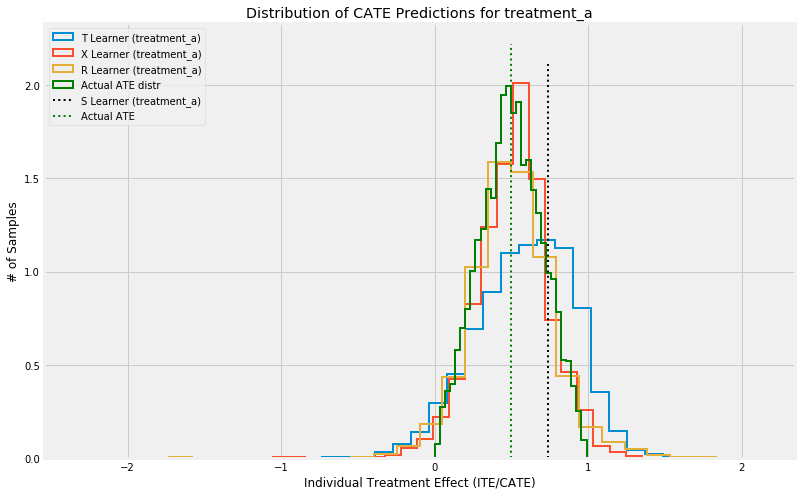

In [46]:
groups = learner_r._classes

alpha = 1
linewidth = 2
bins = 30
for group,idx in sorted(groups.items(), key=lambda x: x[1]):
    plt.figure(figsize=(12,8))
    plt.hist(cate_t[:,idx], alpha=alpha, bins=bins, label='T Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(cate_x[:,idx], alpha=alpha, bins=bins, label='X Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(cate_r[:,idx], alpha=alpha, bins=bins, label='R Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(tau, alpha=alpha, bins=bins, label='Actual ATE distr',
             histtype='step', linewidth=linewidth, color='green', density=True)
    plt.vlines(cate_s[0,idx], 0, plt.axes().get_ylim()[1], label='S Learner ({})'.format(group),
               linestyles='dotted', linewidth=linewidth)
    plt.vlines(tau.mean(), 0, plt.axes().get_ylim()[1], label='Actual ATE',
               linestyles='dotted', linewidth=linewidth, color='green')
    
    plt.title('Distribution of CATE Predictions for {}'.format(group))
    plt.xlabel('Individual Treatment Effect (ITE/CATE)')
    plt.ylabel('# of Samples')
    _=plt.legend()

---
# Multiple Treatment Case

### Generate synthetic data
Note: we randomize the assignment of treatment flag AFTER the synthetic data generation process, so it doesn't make sense to measure accuracy metrics here. Next steps would be to include multi-treatment in the DGP itself.

In [47]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array([('treatment_a' if np.random.random() > 0.2 else 'treatment_b') 
                      if val==1 else 'control' for val in treatment])

e = {group: e for group in np.unique(treatment)}

In [48]:
pd.Series(treatment).value_counts()

control        4892
treatment_a    4052
treatment_b    1056
dtype: int64

## S-Learner

### ATE

In [49]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False, bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9632
INFO:causalml:    RMSE (Treatment):     0.9747
INFO:causalml:   sMAPE   (Control):     0.7990
INFO:causalml:   sMAPE (Treatment):     0.4697
INFO:causalml:    Gini   (Control):     0.4634
INFO:causalml:    Gini (Treatment):     0.4828
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9552
INFO:causalml:    RMSE (Treatment):     0.9388
INFO:causalml:   sMAPE   (Control):     0.7953
INFO:causalml:   sMAPE (Treatment):     0.4901
INFO:causalml:    Gini   (Control):     0.4794
INFO:causalml:    Gini (Treatment):     0.5405


In [50]:
ate_s

array([0.55419741, 0.47773958])

In [51]:
learner_s._classes

{'treatment_a': 0, 'treatment_b': 1}

### ATE w/ Confidence Intervals

In [52]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                   bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9632
INFO:causalml:    RMSE (Treatment):     0.9747
INFO:causalml:   sMAPE   (Control):     0.7990
INFO:causalml:   sMAPE (Treatment):     0.4697
INFO:causalml:    Gini   (Control):     0.4634
INFO:causalml:    Gini (Treatment):     0.4828
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9552
INFO:causalml:    RMSE (Treatment):     0.9388
INFO:causalml:   sMAPE   (Control):     0.7953
INFO:causalml:   sMAPE (Treatment):     0.4901
INFO:causalml:    Gini   (Control):     0.4794
INFO:causalml:    Gini (Treatment):     0.5405


In [53]:
np.vstack((ate_s_lb, ate_s, ate_s_ub))

array([[0.51369214, 0.41488462],
       [0.55419741, 0.47773958],
       [0.59470267, 0.54059455]])

### ATE w/ Boostrap Confidence Intervals

In [54]:
ate_s_b, ate_s_lb_b, ate_s_ub_b = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                         bootstrap_ci=True, n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9632
INFO:causalml:    RMSE (Treatment):     0.9747
INFO:causalml:   sMAPE   (Control):     0.7990
INFO:causalml:   sMAPE (Treatment):     0.4697
INFO:causalml:    Gini   (Control):     0.4634
INFO:causalml:    Gini (Treatment):     0.4828
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9552
INFO:causalml:    RMSE (Treatment):     0.9388
INFO:causalml:   sMAPE   (Control):     0.7953
INFO:causalml:   sMAPE (Treatment):     0.4901
INFO:causalml:    Gini   (Control):     0.4794
INFO:causalml:    Gini (Treatment):     0.5405
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


In [55]:
np.vstack((ate_s_lb_b, ate_s_b, ate_s_ub_b))

array([[0.44009793, 0.44009793],
       [0.55419741, 0.47773958],
       [0.58703486, 0.58703486]])

### CATE

In [56]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9632
INFO:causalml:    RMSE (Treatment):     0.9747
INFO:causalml:   sMAPE   (Control):     0.7990
INFO:causalml:   sMAPE (Treatment):     0.4697
INFO:causalml:    Gini   (Control):     0.4634
INFO:causalml:    Gini (Treatment):     0.4828
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9552
INFO:causalml:    RMSE (Treatment):     0.9388
INFO:causalml:   sMAPE   (Control):     0.7953
INFO:causalml:   sMAPE (Treatment):     0.4901
INFO:causalml:    Gini   (Control):     0.4794
INFO:causalml:    Gini (Treatment):     0.5405


In [57]:
cate_s

array([[0.6262635 , 0.43354154],
       [0.1917026 , 0.05376828],
       [0.69057751, 0.46126521],
       ...,
       [0.65065515, 0.65086162],
       [0.74598098, 0.74454355],
       [0.52633405, 0.43064654]])

### CATE w/ Confidence Intervals

In [58]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
cate_s, cate_s_lb, cate_s_ub = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9632
INFO:causalml:    RMSE (Treatment):     0.9747
INFO:causalml:   sMAPE   (Control):     0.7990
INFO:causalml:   sMAPE (Treatment):     0.4697
INFO:causalml:    Gini   (Control):     0.4634
INFO:causalml:    Gini (Treatment):     0.4828
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9552
INFO:causalml:    RMSE (Treatment):     0.9388
INFO:causalml:   sMAPE   (Control):     0.7953
INFO:causalml:   sMAPE (Treatment):     0.4901
INFO:causalml:    Gini   (Control):     0.4794
INFO:causalml:    Gini (Treatment):     0.5405
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


In [59]:
cate_s

array([[0.6262635 , 0.43354154],
       [0.1917026 , 0.05376828],
       [0.69057751, 0.46126521],
       ...,
       [0.65065515, 0.65086162],
       [0.74598098, 0.74454355],
       [0.52633405, 0.43064654]])

In [60]:
cate_s_lb

array([[ 0.32171244,  0.11003632],
       [ 0.08419962, -0.14059955],
       [ 0.31463388,  0.18488826],
       ...,
       [ 0.36679429,  0.28329928],
       [ 0.53323452,  0.48045244],
       [ 0.20163021, -0.00209917]])

In [61]:
cate_s_ub

array([[0.87833115, 0.79856594],
       [0.62153919, 0.64727988],
       [0.92041856, 0.83928279],
       ...,
       [0.79777692, 0.91094386],
       [0.99737912, 0.95628079],
       [0.7473262 , 0.83755107]])

## T-Learner

### ATE w/ Confidence Intervals

In [62]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.9338
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4571
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.5502
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.8238
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4445
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.6901


In [63]:
np.vstack((ate_t_lb, ate_t, ate_t_ub))

array([[0.5266868 , 0.46472956],
       [0.5663626 , 0.52182836],
       [0.60603839, 0.57892717]])

### ATE w/ Boostrap Confidence Intervals

In [64]:
ate_t_b, ate_t_lb_b, ate_t_ub_b = learner_t.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.9338
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4571
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.5502
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.8238
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4445
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.6901
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


In [65]:
np.vstack((ate_t_lb_b, ate_t_b, ate_t_ub_b))

array([[0.48272348, 0.48272348],
       [0.5663626 , 0.52182836],
       [0.65502001, 0.65502001]])

### CATE

In [66]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.9338
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4571
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.5502
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.8238
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4445
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.6901


In [67]:
cate_t

array([[ 0.66959965,  0.25875497],
       [-0.01934159, -0.02933288],
       [ 0.4400022 ,  0.28678226],
       ...,
       [ 0.56788802,  0.81711674],
       [ 0.84892786,  0.78944492],
       [ 0.52915788,  0.76359272]])

### CATE w/ Confidence Intervals

In [68]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t, cate_t_lb, cate_t_ub = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100,
                                                    bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.9338
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4571
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.5502
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.8238
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4445
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.6901
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


In [69]:
cate_t

array([[ 0.66959965,  0.25875497],
       [-0.01934159, -0.02933288],
       [ 0.4400022 ,  0.28678226],
       ...,
       [ 0.56788802,  0.81711674],
       [ 0.84892786,  0.78944492],
       [ 0.52915788,  0.76359272]])

In [70]:
cate_t_lb

array([[ 0.12842939, -0.28066461],
       [-0.29198704, -0.69388282],
       [-0.16148863, -0.27440224],
       ...,
       [ 0.2791278 ,  0.01516045],
       [ 0.43462309,  0.25942732],
       [-0.39177527, -0.45913519]])

In [71]:
cate_t_ub

array([[1.1084685 , 1.17010369],
       [0.77816445, 0.74418546],
       [1.16087661, 1.14991211],
       ...,
       [1.3415089 , 1.35408813],
       [1.35678474, 1.57358396],
       [1.1060796 , 1.32264085]])

## X-Learner

### ATE w/ Confidence Intervals

In [72]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.9338
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4571
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.5502
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.8238
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4445
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.6901


In [73]:
np.vstack((ate_x_lb, ate_x, ate_x_ub))

array([[0.45965245, 0.40041945],
       [0.49904679, 0.45713398],
       [0.53844113, 0.51384852]])

### ATE w/ Boostrap Confidence Intervals

In [74]:
ate_x_b, ate_x_lb_b, ate_x_ub_b = learner_x.estimate_ate(X=X, p=e, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.9338
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4571
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.5502
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.8238
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4445
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.6901
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


In [75]:
np.vstack((ate_x_lb_b, ate_x_b, ate_x_ub_b))

array([[0.41907427, 0.41907427],
       [0.49904679, 0.45713398],
       [0.57759127, 0.57759127]])

### CATE

In [76]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x = learner_x.fit_predict(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.9338
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4571
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.5502
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.8238
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4445
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.6901


In [77]:
cate_x

array([[0.62528475, 0.43505457],
       [0.35474947, 0.28944603],
       [0.4011104 , 0.26894857],
       ...,
       [0.59754022, 0.61811476],
       [0.63506061, 0.54080939],
       [0.53305645, 0.77341021]])

### CATE w/ Confidence Intervals

In [78]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x, cate_x_lb, cate_x_ub = learner_x.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.9338
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4571
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.5502
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9441
INFO:causalml:    RMSE (Treatment):     0.8238
INFO:causalml:   sMAPE   (Control):     0.7870
INFO:causalml:   sMAPE (Treatment):     0.4445
INFO:causalml:    Gini   (Control):     0.5028
INFO:causalml:    Gini (Treatment):     0.6901
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


In [79]:
learner_x._classes

{'treatment_a': 0, 'treatment_b': 1}

In [80]:
cate_x

array([[0.62528475, 0.43505457],
       [0.35474947, 0.28944603],
       [0.4011104 , 0.26894857],
       ...,
       [0.59754022, 0.61811476],
       [0.63506061, 0.54080939],
       [0.53305645, 0.77341021]])

In [81]:
cate_x_lb

array([[ 0.14504296, -0.30402477],
       [-0.28746815, -0.49703231],
       [-0.15113416, -0.31781545],
       ...,
       [ 0.07736763, -0.35729331],
       [ 0.26527608, -0.03492624],
       [-0.35030588, -0.54564259]])

In [82]:
cate_x_ub

array([[1.17064105, 1.44692207],
       [0.77762326, 1.04858505],
       [1.27686583, 1.68375523],
       ...,
       [1.32888781, 1.48911467],
       [1.23228441, 1.40093811],
       [1.31979665, 1.85867427]])

## R-Learner

### ATE w/ Confidence Intervals

In [83]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [84]:
np.vstack((ate_r_lb, ate_r, ate_r_ub))

array([[0.49861923, 0.49612921],
       [0.49903124, 0.49677567],
       [0.49944325, 0.49742213]])

### ATE w/ Boostrap Confidence Intervals

In [85]:
ate_r_b, ate_r_lb_b, ate_r_ub_b = learner_r.estimate_ate(X=X, p=e, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


In [86]:
np.vstack((ate_r_lb_b, ate_r_b, ate_r_ub_b))

array([[0.42966299, 0.42966299],
       [0.49650271, 0.49148246],
       [0.55891948, 0.55891948]])

### CATE

In [87]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [88]:
cate_r

array([[0.38065842, 0.69341463],
       [0.42421407, 0.36158347],
       [0.35504133, 0.38868353],
       ...,
       [0.59072393, 0.59547216],
       [0.57494015, 0.54867923],
       [0.4471325 , 0.51386422]])

### CATE w/ Confidence Intervals

In [89]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r, cate_r_lb, cate_r_ub = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


In [90]:
cate_r

array([[0.54248059, 0.82205963],
       [0.37086791, 0.34841993],
       [0.37698507, 0.33121252],
       ...,
       [0.60834652, 0.51496494],
       [0.4606657 , 0.48004779],
       [0.50237077, 0.43717539]])

In [91]:
cate_r_lb

array([[-7.04514402e-01, -5.96348843e-01],
       [-6.90049151e-01, -7.73702276e-01],
       [-5.73202890e-01, -9.53516939e-01],
       ...,
       [-3.80926085e-01, -4.86176623e-01],
       [-1.34975615e-01,  8.07089359e-04],
       [-8.32374361e-01, -8.37146640e-01]])

In [92]:
cate_r_ub

array([[1.6522211 , 1.69132043],
       [1.1471369 , 1.37962066],
       [1.38177827, 1.72919002],
       ...,
       [1.60461781, 1.92559459],
       [1.6408923 , 1.90694135],
       [2.07625948, 2.1059757 ]])